In [64]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, MaxPooling2D, Dropout
from keras.applications import DenseNet201
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [8]:
train_data_dir = "preprocessed/train"

In [35]:
valid_data_dir =  "preprocessed/valid"

In [12]:
test_data_dir = "preprocessed/test"

In [9]:
labels = os.listdir(train_data_dir)

Number of no wildfire images : 14500
Number of wildfire images : 15750


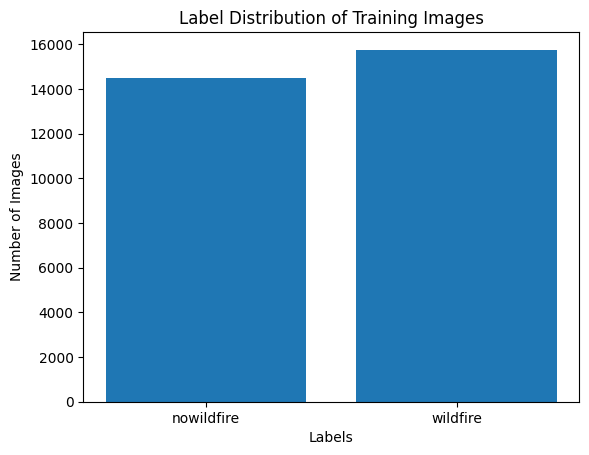

In [16]:
label_counts = Counter()
for label in labels:
    label_path = os.path.join(train_data_dir, label)
    label_counts[label] = len(os.listdir(label_path))

print("Number of no wildfire images : " + str(label_counts["nowildfire"]))
print("Number of wildfire images : " + str(label_counts["wildfire"]))

# Plot the distribution
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Label Distribution of Training Images')
plt.show()

In [24]:
# Set image size for resizing
img_width, img_height = 224, 224

batch_size = 64

# Create data generators for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
validation_datagen = ImageDataGenerator(rescale=1./255)

In [43]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                             target_size=(img_width, img_height),
                                             batch_size=batch_size,
                                             class_mode='binary') 

Found 30250 images belonging to 2 classes.


In [40]:
valid_generator = validation_datagen.flow_from_directory(valid_data_dir,
                                                 target_size=(img_width, img_height),
                                                 batch_size=batch_size,
                                                 class_mode='binary')

Found 3319 images belonging to 2 classes.


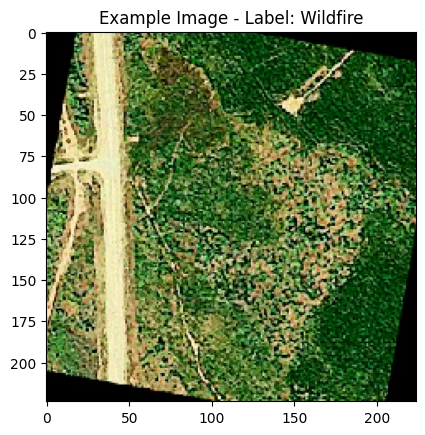

In [50]:
example_batch = next(train_generator)

# Extract the first image and label from the batch
example_image = example_batch[0][0]
example_label = example_batch[1][0]

if example_label == 1.0:
    label = "Wildfire"
else:
    label = "No Wildfire"

# Display the example image and label
plt.imshow(example_image)
plt.title(f"Example Image - Label: {label}")
plt.show()

In [75]:
model = keras.Sequential()

# Feature Learning Layers
model.add(Conv2D(32,                  # Number of filters/Kernels
                     (3,3),               # Size of kernels (3x3 matrix)
                     strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                     padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input. 
                    input_shape = (224, 224, 3) # Input image shape
                    ))
model.add(Activation('relu'))# Activation function
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5,5), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(256, (5,5), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

# Flattening tensors
model.add(Flatten())

# Fully-Connected Layers
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation = 'softmax')) # Classification layer

In [76]:
# Compiling model
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), # 1e-4
              loss = 'categorical_crossentropy', # Ideal for multiclass tasks
              metrics = ['accuracy']) # Evaluation metric

In [77]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 activation_38 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 batch_normalization_35 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_38 (Dropout)        (None, 112, 112, 32)      0         
                                                                 
 conv2d_36 (Conv2D)          (None, 112, 112, 64)     

In [73]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [78]:
# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),  # Adjust based on data size
    epochs=10,  # Adjust number of epochs
    validation_data=valid_generator,
    validation_steps=len(valid_generator),  # Adjust based on data size
    callbacks=[early_stopping, checkpoint]  # Add callbacks as needed
)

Epoch 1/10


C:\Users\pl23927\AppData\Local\Temp\ipykernel_12788\1532429336.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
c:\python3\lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


473/473 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5207

c:\python3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


473/473 [==============================] - 3000s 6s/step - loss: 0.0000e+00 - accuracy: 0.5207 - val_loss: 0.0000e+00 - val_accuracy: 0.1503
Epoch 2/10
473/473 [==============================] - 3293s 7s/step - loss: 0.0000e+00 - accuracy: 0.5207 - val_loss: 0.0000e+00 - val_accuracy: 0.1503
Epoch 3/10
473/473 [==============================] - 3772s 8s/step - loss: 0.0000e+00 - accuracy: 0.5207 - val_loss: 0.0000e+00 - val_accuracy: 0.1503
Epoch 4/10
473/473 [==============================] - 2535s 5s/step - loss: 0.0000e+00 - accuracy: 0.5207 - val_loss: 0.0000e+00 - val_accuracy: 0.1503
Epoch 5/10
473/473 [==============================] - 2609s 6s/step - loss: 0.0000e+00 - accuracy: 0.5207 - val_loss: 0.0000e+00 - val_accuracy: 0.1503
Epoch 6/10
473/473 [==============================] - 3066s 6s/step - loss: 0.0000e+00 - accuracy: 0.5207 - val_loss: 0.0000e+00 - val_accuracy: 0.1503


In [79]:
# Loading best weights
model.load_weights('best_model.h5')

In [80]:
preds = model.predict(valid_generator)  # Running model on the validation dataset
val_loss, val_acc = model.evaluate(valid_generator) # Obtaining Loss and Accuracy on the val dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

52/52 [==============================] - 44s 843ms/step - loss: 0.0000e+00 - accuracy: 0.1503

Validation Loss:  0.0

Validation Accuracy:  15.0 %


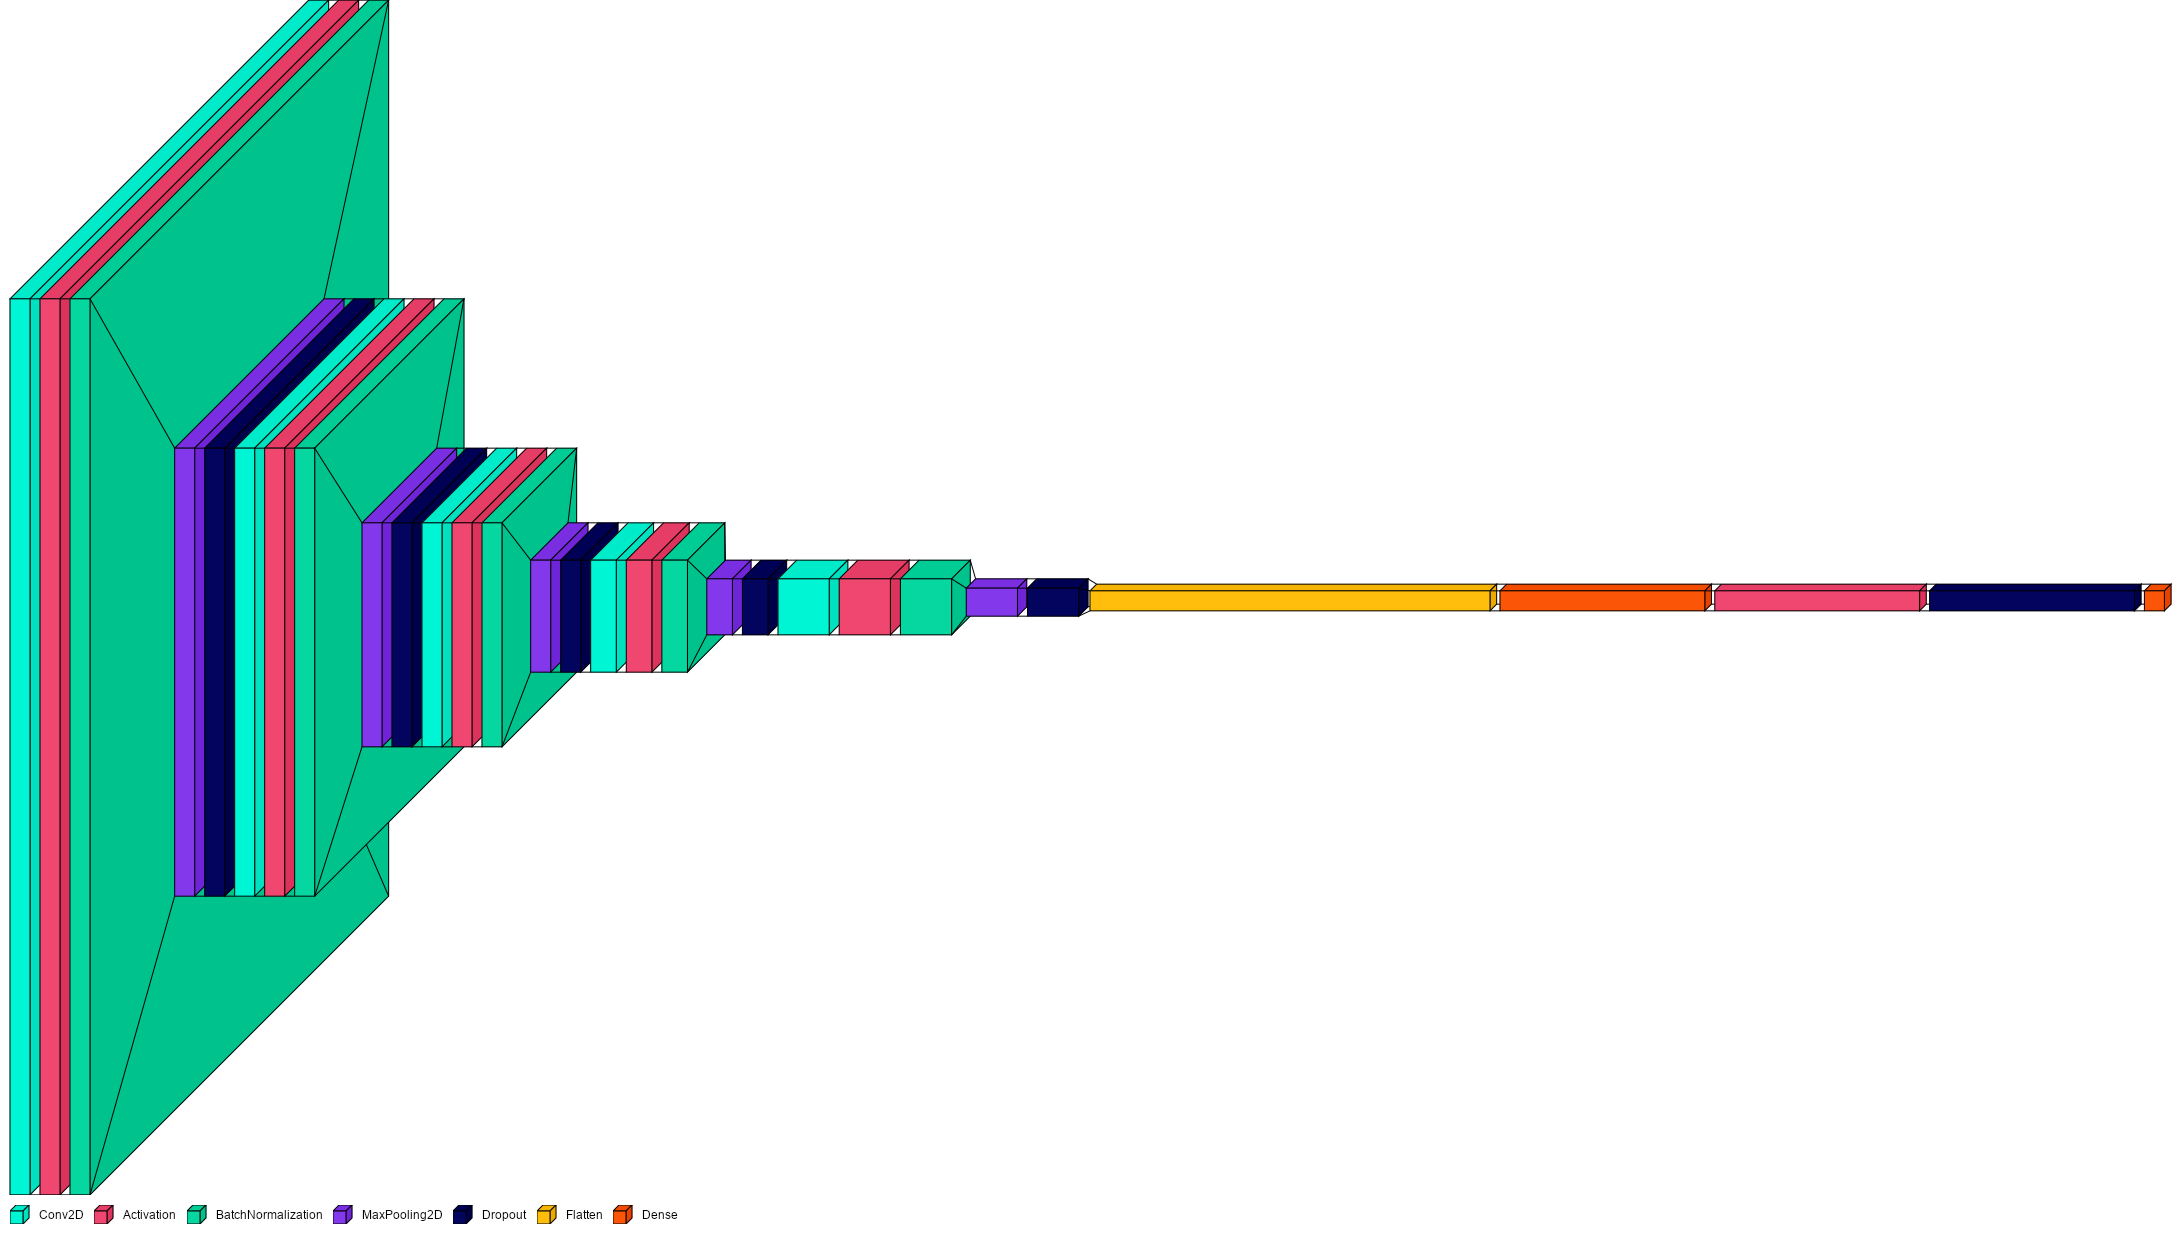

In [28]:
from tensorflow.keras import layers
from collections import defaultdict
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
visualkeras.layered_view(model, legend=True, font=font,color_map=color_map)